# **Imports**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import * 
from keras.layers import * 
from keras.preprocessing import image
import PIL
from keras import optimizers, losses
from keras.optimizers import *
import os
from keras import Sequential
from keras import layers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# **Get & Preprocess Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/GP NTI/Train',
        target_size=(224, 224), batch_size=64,class_mode='categorical',shuffle=False)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/GP NTI/Test',
            target_size=(224, 224), batch_size=64,class_mode='categorical',shuffle=False)


Found 3890 images belonging to 95 classes.
Found 1039 images belonging to 95 classes.


In [4]:
train_path = "/content/drive/MyDrive/GP NTI/Train"
test_path = "/content/drive/MyDrive/GP NTI/Test"

In [5]:
train_set.class_indices

{'100': 0,
 'Angry': 1,
 'Bury': 2,
 'among': 3,
 'ankh': 4,
 'aroura': 5,
 'at': 6,
 'bad thinking': 7,
 'bandage': 8,
 'bee': 9,
 'belong': 10,
 'birth': 11,
 'board game': 12,
 'book': 13,
 'boy': 14,
 'branch': 15,
 'bread': 16,
 'brewer': 17,
 'builder': 18,
 'canal': 19,
 'cloth on pole': 20,
 'cobra': 21,
 'composite_bow': 22,
 'cooked': 23,
 'corpse': 24,
 'dessert': 25,
 'divide': 26,
 'duck': 27,
 'elephant': 28,
 'enclosed mound': 29,
 'eye': 30,
 'fabric': 31,
 'face': 32,
 'falcon': 33,
 'fingre': 34,
 'fish': 35,
 'flail': 36,
 'folded': 37,
 'foot': 38,
 'galena': 39,
 'giraffe': 40,
 'he': 41,
 'her': 42,
 'hit': 43,
 'horn': 44,
 'king': 45,
 'leg': 46,
 'length of a human arm': 47,
 'life spirit': 48,
 'limits': 49,
 'lion': 50,
 'lizard': 51,
 'loaf': 52,
 'loaf of bread': 53,
 'man': 54,
 'mascot': 55,
 'meet': 56,
 'mother': 57,
 'mouth': 58,
 'musical instrument': 59,
 'nile fish': 60,
 'not': 61,
 'now': 62,
 'nurse': 63,
 'nursing': 64,
 'occur': 65,
 'one': 66,

In [6]:
batch_size = 64
imageSize = 224

target_dims = (imageSize, imageSize, 3)
num_classes = 95

train_len = 3890
base_dir = os.path.join(os.getcwd(), "/content/drive/MyDrive/GP NTI")
train_dir = os.path.join(base_dir, '/content/drive/MyDrive/GP NTI/Train')
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(imageSize, imageSize),
    batch_size=batch_size)
              

Found 3890 files belonging to 95 classes.
Using 3501 files for training.


In [7]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.09,
    subset="validation",
    seed=123,
    image_size=(imageSize, imageSize),
    batch_size=batch_size)

Found 3890 files belonging to 95 classes.
Using 350 files for validation.


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.01,
    subset="validation",
    seed=123,
    image_size=(imageSize, imageSize),
    batch_size=batch_size)

Found 3890 files belonging to 95 classes.
Using 38 files for validation.


# **Build Model**

In [9]:
from tensorflow.keras.applications import VGG19

model = Sequential()

inp=VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
inp.output

80150528/80134624 [==============================] - 0s 0us/step


<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [10]:
for layer in inp.layers:
    layer.trainable=False 

In [11]:
x=Flatten()(inp.output)
prediction=Dense(95, activation='softmax')(x)
model=Model(inputs=inp.input,outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

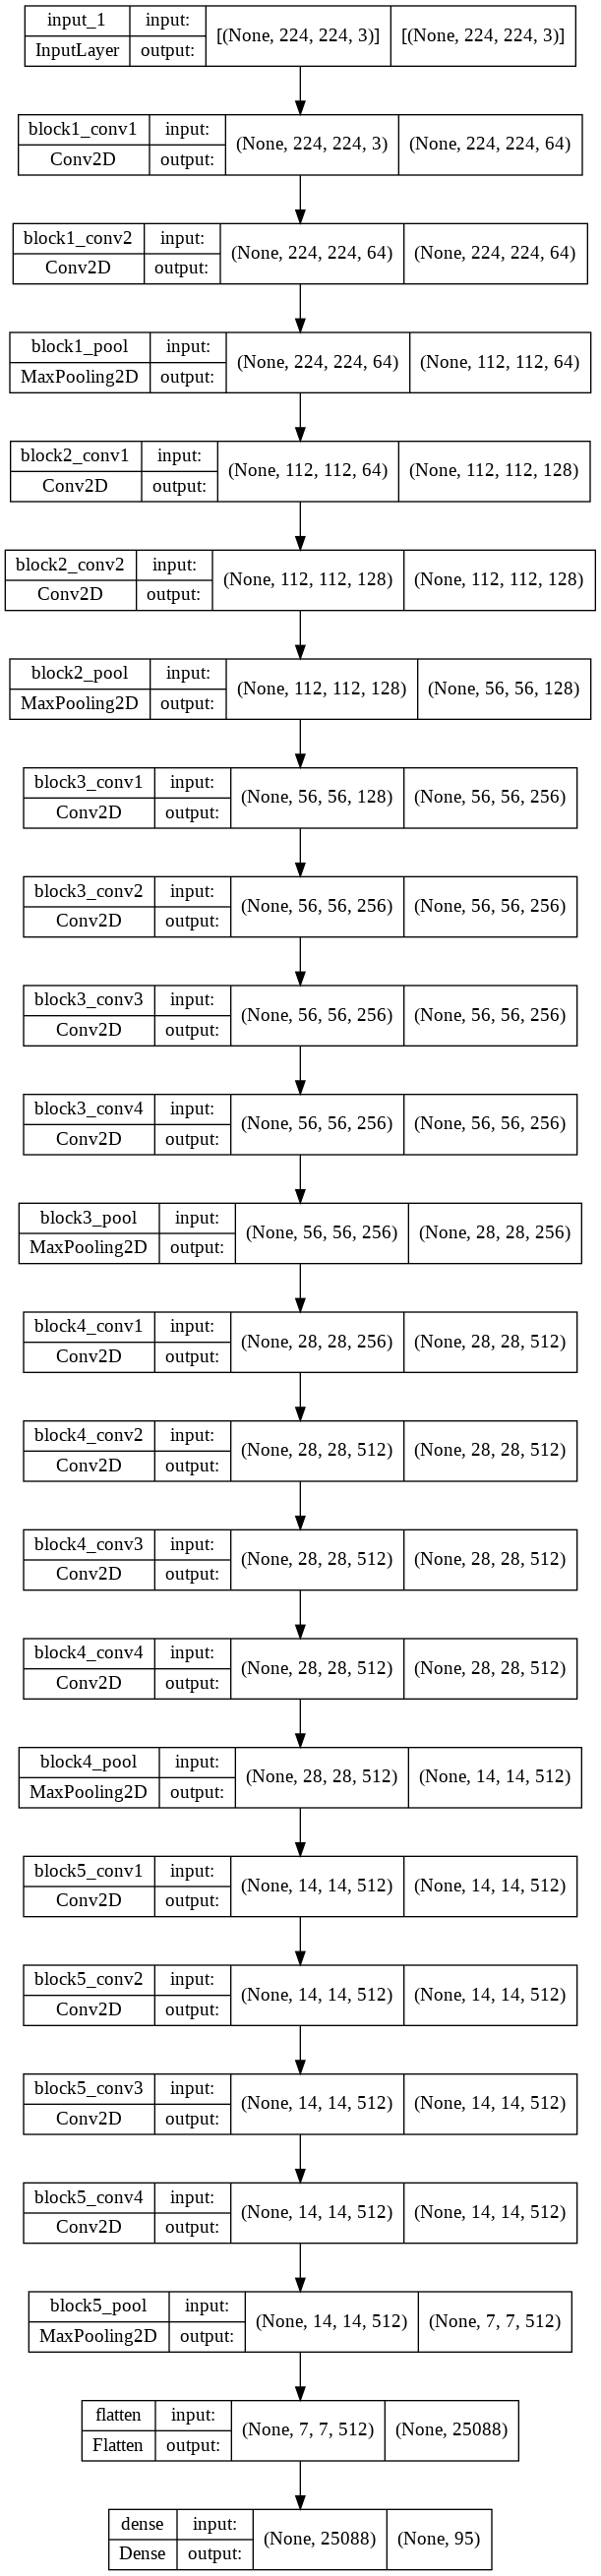

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model= model , show_shapes=True)

**Compile Model:**

In [13]:
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['acc'])

In [14]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

annealer = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=3, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('/temp/{epoch}_VGG16.h5', verbose=1, save_best_only=False, mode='auto', save_freq='epoch')

**Train Model:**

In [15]:
history = model.fit(
                  train_ds,
                  validation_data=validation_ds,
                  epochs=10,
                  batch_size=64,
                  callbacks=[annealer, checkpoint],
                  steps_per_epoch=len(train_ds),
                  validation_steps=len(test_ds)
                )

Epoch 1/10
55/55 [==============================] - ETA: 0s - loss: 6.9389 - acc: 0.6018 
Epoch 1: saving model to /temp/1_VGG16.h5
55/55 [==============================] - 795s 12s/step - loss: 6.9389 - acc: 0.6018 - val_loss: 1.7040 - val_acc: 0.8125 - lr: 0.0010
Epoch 2/10
55/55 [==============================] - ETA: 0s - loss: 0.6453 - acc: 0.9280
Epoch 2: saving model to /temp/2_VGG16.h5
55/55 [==============================] - 21s 368ms/step - loss: 0.6453 - acc: 0.9280 - val_loss: 1.0715 - val_acc: 0.8750 - lr: 0.0010
Epoch 3/10
55/55 [==============================] - ETA: 0s - loss: 0.4139 - acc: 0.9589
Epoch 3: saving model to /temp/3_VGG16.h5
55/55 [==============================] - 22s 371ms/step - loss: 0.4139 - acc: 0.9589 - val_loss: 1.8736 - val_acc: 0.8594 - lr: 0.0010
Epoch 4/10
55/55 [==============================] - ETA: 0s - loss: 0.1984 - acc: 0.9774
Epoch 4: saving model to /temp/4_VGG16.h5
55/55 [==============================] - 22s 373ms/step - loss: 0.1984 

# **Plotting**

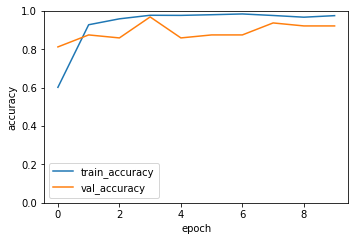

In [16]:
# Plotting Loss & Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(history.history['acc'], label = 'train_accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

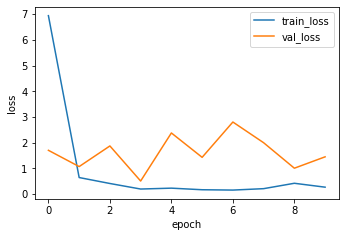

In [17]:
# Plotting Loss & Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# **Evaluate Model**

In [18]:
model.evaluate(test_ds)

1/1 [==============================] - 3s 3s/step - loss: 3.3653 - acc: 0.7895


[3.365330696105957, 0.7894737124443054]

In [19]:
model.evaluate(train_ds)

55/55 [==============================] - 21s 357ms/step - loss: 0.2133 - acc: 0.9783


[0.21333789825439453, 0.978291928768158]

# **Prediction**

In [20]:
y_pred=model.predict(test_ds)
y_pred.shape

(38, 95)

In [21]:
class_names = train_ds.class_names
actual = []
pred = []
for images, labels in test_ds:
    for i in range(0, len(images)):
        image = images[i]
        image = np.expand_dims(image, axis=0)
        result = model.predict(image)
        pred.append(class_names[np.argmax(result)])
        actual.append(class_names[labels[i].numpy()])

In [22]:
count=0
for i in range(len(actual)):
    if actual[i]==pred[i]:
        count+=1

print("Accuracy on test data is: ",(count/len(actual))*100)

Accuracy on test data is:  78.94736842105263


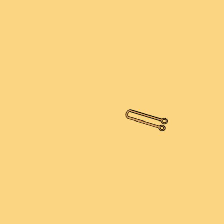

In [24]:
from keras.preprocessing import image
img1 =image.load_img('/content/drive/MyDrive/GP NTI/Test/at/at (43).jpg',target_size =(224,224))
img1